In [1]:
import numpy as np

import torch
import torch.nn as nn
import pandas
from torch.utils.data import DataLoader,Dataset, random_split, Subset
from matplotlib.pylab import plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
discharge_capacities = np.load(r"./Datasets/discharge_capacity.npy", allow_pickle=True)
discharge_capacities = discharge_capacities.tolist()

charge_indices =[1429, 1677, 1738, 1095, 1316, 807, 457, 645, 791, 579, 653, 524, 637, 634, 501, 579, 375, 396, 759, 762, 631, 645, 621, 637, 682, 516, 649, 533, 554, 541, 510, 511, 467, 442, 448, 721, 789, 509, 469, 441, 428, 210, 85, 320, 237, 325, 355, 385, 426, 353, 341, 365, 357, 369, 367, 341, 373, 365, 381, 398, 368, 339, 348, 345, 381, 366, 355, 365, 384, 386, 370, 338, 397, 350, 339, 333, 373, 310, 342, 339, 333, 360, 309, 545, 756, 798, 840, 787, 611, 482, 1417, 611, 780, 811, 602, 693, 601, 635, 649, 1259]


In [3]:
def get_data(discharge_capacities,window_size,stride,channels):
        
        train_data =[]

        for index,battery in enumerate(discharge_capacities):
                battery = np.array(battery)
                battery_name = "battery" + str(index)
                i = charge_indices[index]
                print(charge_indices[index] - len(battery[0]))
                while(i+stride+window_size+1 <= int(len(battery[0])) and len(battery[0][i:i+window_size]) == window_size):
                        train_data.append((battery[:channels,i:i+window_size], battery[0,i+window_size],battery_name ))
                        i = i+stride
                                                                        
        return train_data

In [4]:
import math
class CNN_Model(nn.Module):
    
    def __init__(self,input_size, channels):
        super(CNN_Model, self).__init__()
        self.name = "CNN"
        filter_size_1 = 5
        filter_size   = 5
        
        self.conv1 = nn.Conv1d(channels,16,kernel_size = filter_size_1, stride=1,padding=filter_size_1//2)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.max_pool1 = nn.MaxPool1d(2)
        

        self.conv2 = nn.Conv1d(16,32, kernel_size = filter_size_1, stride = 1,padding=filter_size_1 //2)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.max_pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32,64, kernel_size = filter_size, stride = 1,padding=filter_size //2)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.max_pool3 = nn.MaxPool1d(2)

       
        self.flatten_size = 128*math.floor(input_size/(2*2*2*2))
        self.flatten = nn.Flatten(start_dim=1)
        
        self.Linear1 = nn.Linear(self.flatten_size, input_size)
        self.batch_norm_linear = nn.BatchNorm1d(input_size)
        # self.a = nn.Linear()
        self.Linear2 = nn.Linear(input_size,1)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        # print(self.flatten_size)
        
        
        
    def forward(self,x):
        # x= x.view(x.shape[0],1,x.shape[1])
        
        out = self.conv1(x)
        # out = self.relu(out)
        out = self.batch_norm1(out)
        out = self.dropout(out)
        out = self.max_pool1(out)

        out = self.conv2(out)
        # out = self.relu(out)
        out = self.batch_norm2(out)
        out = self.dropout(out)
        out = self.max_pool2(out)   

        # out = self.conv3(out)
        # out = self.relu(out)
        # out = self.batch_norm3(out)
        # out = self.dropout(out)
        # out = self.max_pool3(out) 

        out = self.flatten(out)
        
        out = self.Linear1(out)  
        out = self.Linear2(out)

        return out

In [5]:
class battery_dataloader(Dataset):
    
    def __init__(self,data):
        self.data = data
    

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        inp =  torch.tensor(self.data[idx][0]).float()
        output = torch.tensor(self.data[idx][1]).float()
        battery_name = self.data[idx][2]
        
        return inp, output, battery_name

In [6]:
channels = 1
window_size = 50
stride =1
train_data= get_data(discharge_capacities[:100],window_size,stride,channels)

obj_train  = battery_dataloader(train_data)
train_dataloader = DataLoader(obj_train, batch_size=128,shuffle=True)

-422
-482
-498
-338
-392
-266
-178
-224
-262
-208
-226
-194
-224
-222
-189
-208
-158
-162
-254
-254
-222
-224
-220
-222
-234
-192
-226
-197
-202
-200
-192
-192
-180
-174
-176
-244
-261
-192
-181
-174
-170
-116
-85
-144
-124
-146
-152
-160
-170
-152
-150
-155
-152
-156
-156
-148
-158
-155
-159
-164
-156
-148
-150
-150
-160
-156
-152
-154
-160
-160
-156
-148
-163
-152
-148
-147
-157
-142
-150
-148
-146
-154
-140
-200
-252
-264
-274
-260
-216
-184
-418
-216
-258
-266
-214
-238
-214
-222
-226
-378


In [7]:
next(iter(train_dataloader))[0].shape

torch.Size([128, 1, 50])

In [8]:
from torchmetrics.classification import BinaryAccuracy


def train_model(window_size,channels,train_dataloader,epochs):

    model = CNN_Model(window_size,channels)
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas= (0.9, 0.99))
    criterion = nn.MSELoss()
    # metric = BinaryAccuracy()

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

   

    for epoch in range(epochs):
        total_loss = 0
        model.train()
        model.requires_grad_(True)
        acc = 0
        total_loss = 0
        total = 0
        total_batches = 0
        for x, y ,_ in train_dataloader:
            
            x = x.to(device=device)
            y = y.to(device=device)
            out = model(x)
            
            loss = criterion(out,y.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size()[0]
            total += x.size()[0]
            total_batches +=1


        print("Loss = {} ".format(total_loss/total))
    return model

In [9]:
model = train_model(window_size, channels,train_dataloader,100) 

Loss = 0.03485061479432414 
Loss = 0.0024556993729141696 
Loss = 0.00125799451388239 
Loss = 0.0009701765121228755 
Loss = 0.0008592682931322062 
Loss = 0.001106647107344666 
Loss = 0.000989873584202664 
Loss = 0.0006632670753789763 
Loss = 0.0004249261013278861 
Loss = 0.0005701197703794472 
Loss = 0.0005867621405659349 
Loss = 0.00036580192717730625 
Loss = 0.0003795898300961326 
Loss = 0.0004036478509573893 
Loss = 0.00033656880188316673 
Loss = 0.0002460933952743226 
Loss = 0.0003677942144384052 
Loss = 0.00021957486342862715 
Loss = 0.0002906862491611247 
Loss = 0.00034313869011780074 
Loss = 0.00021350999228987193 
Loss = 0.000244044781481805 
Loss = 0.00021656188313293306 
Loss = 0.00021875460045569096 
Loss = 0.0002155783242948072 
Loss = 0.0002199680279660347 
Loss = 0.0002066128840277708 
Loss = 0.0002209588906094389 
Loss = 0.00023582872745344372 
Loss = 0.00022881872045448642 
Loss = 0.00015844970489535228 
Loss = 0.0001923209968197452 
Loss = 0.00016862908471025728 
Loss =

In [10]:
battery_data = np.array(discharge_capacities[1])[:1,charge_indices[0]:]

In [11]:
model.eval()
i =0
last_window = np.reshape(battery_data[:,0:window_size], (1,1,window_size))

outs =[]    
while(i!=500): 
    out = model(torch.tensor(last_window).float()).item()
    last_window = np.append(last_window,out)
    last_window = np.reshape(last_window[-window_size:],(1,1,50))
    outs.append(out)
    i = i+1 

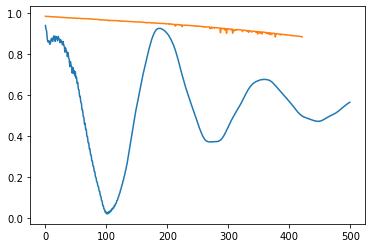

In [12]:
plt.plot(outs)
plt.plot(discharge_capacities[0][0][charge_indices[0]:])